In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path='/content/drive/MyDrive/IITB/project/data'

In [ ]:
import pandas as pd

In [ ]:
df_features=pd.read_csv(data_path+'/df_features_trials.csv')

In [ ]:
df_features.shape

(1448, 115)

## Compute class weights (for model training)

In [ ]:
from sklearn.utils import compute_class_weight
import numpy as np

#  have a label column (could be 'verdict' or your emotion label)
y = df_features['verdict'].astype(str).values  # or df_features['label']

classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {cls: w for cls,w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# In sklearn estimators  can pass class_weight=class_weight_dict for some classifiers


Class weights: {'CORRECT': np.float64(0.34774255523535064), 'INCORRECT': np.float64(1.0903614457831325), 'SKIP': np.float64(9.783783783783784), 'Unknown': np.float64(9.526315789473685)}


## Oversampling with SMOTE (only on numeric features & on training set)

In [ ]:
# Select numeric features
feature_cols = [c for c in df_features.columns
                if c not in ['Student_ID','routineStart','routineEnd','verdict','QuestionKey','label', 'Key', 'Category', 'QuestionNumber', 'matchOrnomatch', 'Difficulty', 'File_Type', 'routineStamp']]

In [ ]:
# see which of selected columns are non-numeric
non_num_cols = df_features[feature_cols].select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_num_cols)

Non-numeric columns: Index([], dtype='object')


## Replace ±inf with NaN.

Fill NaN with 0 (or some other imputation).

In [ ]:
# start from your numeric features
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['routineStart','routineEnd','Student_ID']]

# make a copy
X_df = df_features[numeric_cols].copy()

# replace inf with NaN
X_df = X_df.replace([np.inf, -np.inf], np.nan)

# fill remaining NaN with 0 or column mean
X_df = X_df.fillna(0)

# now convert to numpy
X = X_df.values

# label
y = df_features['verdict'].astype(str).values

## check extreme values before SMOTE:

In [ ]:
print("Max value in X:", np.nanmax(X))
print("Min value in X:", np.nanmin(X))
print("Any inf:", np.isinf(X).any()) # true if  haave inf



Max value in X: 1025.0
Min value in X: -47.68144079357869
Any inf: False


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

train_idx, test_idx = train_test_split(df_features.index, test_size=0.2, random_state=42, stratify=y)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.unique(y_train, return_counts=True))
print("After  SMOTE:", np.unique(y_res, return_counts=True))


Before SMOTE: (array(['CORRECT', 'INCORRECT', 'SKIP', 'Unknown'], dtype=object), array([833, 265,  30,  30]))
After  SMOTE: (array(['CORRECT', 'INCORRECT', 'SKIP', 'Unknown'], dtype=object), array([833, 833, 833, 833]))


## Undersampling majority class

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)
print("Undersampled distribution:", np.unique(y_under, return_counts=True))


Undersampled distribution: (array(['CORRECT', 'INCORRECT', 'SKIP', 'Unknown'], dtype=object), array([30, 30, 30, 30]))


## have a lot more CORRECT samples than SKIP/Unknown, SMOTE (oversampling) is typically preferable.
Undersampling can be used for quick baseline tests but you lose most of your data.

## Baseline Models (tabular features)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Select numeric features
feature_cols = [c for c in df_features.columns
                if c not in ['Student_ID','routineStart','routineEnd','verdict','QuestionKey','label', 'Key', 'Category', 'QuestionNumber', 'matchOrnomatch', 'Difficulty', 'File_Type', 'routineStamp']]
X_df = df_features[feature_cols].copy()
X_df = X_df.replace([np.inf, -np.inf], np.nan).fillna(0)

# Print data types to verify all features are numeric
print("Data types of features before converting to numpy:")
print(X_df.dtypes)

X = X_df.values
y = df_features['verdict'].astype(str).values  # or your 'label' column

train_idx, test_idx = train_test_split(df_features.index, test_size=0.2, stratify=y, random_state=42)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

Data types of features before converting to numpy:
ResponseTime                       float64
Cat2FeedbackTime                   float64
delta_mean                         float64
delta_std                          float64
theta_mean                         float64
                                    ...   
Yaw_occurrence                       int64
Roll_mean                          float64
Roll_occurrence                      int64
Interocular Distance_mean          float64
Interocular Distance_occurrence      int64
Length: 104, dtype: object


In [ ]:
import os

# Define paths for saving
test_dir = "/content/drive/MyDrive/IITB/test_sets"
X_test_path = os.path.join(test_dir, "X_test.npy")
y_test_path = os.path.join(test_dir, "y_test.npy")

# Create the directory if it doesn't exist
if not os.path.exists(test_dir):
    os.makedirs(test_dir)
    print(f"✅ Directory created at {test_dir}")

# Save X_test if not already present
if not os.path.exists(X_test_path):
    np.save(X_test_path, X_test)
    print(f"✅ X_test saved to {X_test_path}")
else:
    print(f"⚠️ X_test already exists at {X_test_path}. Skipping save.")

# Save y_test if not already present
if not os.path.exists(y_test_path):
    np.save(y_test_path, y_test)
    print(f"✅ y_test saved to {y_test_path}")
else:
    print(f"⚠️ y_test already exists at {y_test_path}. Skipping save.")

⚠️ X_test already exists at /content/drive/MyDrive/IITB/test_sets/X_test.npy. Skipping save.
⚠️ y_test already exists at /content/drive/MyDrive/IITB/test_sets/y_test.npy. Skipping save.


In [ ]:
# Optionally apply SMOTE here on X_train, y_train (like  did)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest:\n", classification_report(y_test, rf.predict(X_test)))
print(confusion_matrix(y_test, rf.predict(X_test)))

Random Forest:
               precision    recall  f1-score   support

     CORRECT       0.73      0.78      0.76       208
   INCORRECT       0.27      0.22      0.24        67
        SKIP       0.10      0.14      0.12         7
     Unknown       0.00      0.00      0.00         8

    accuracy                           0.61       290
   macro avg       0.28      0.29      0.28       290
weighted avg       0.59      0.61      0.60       290

[[162  39   5   2]
 [ 48  15   3   1]
 [  5   1   1   0]
 [  6   1   1   0]]


## Saving the models

In [ ]:
from joblib import dump
import os

models_dir = "/content/drive/MyDrive/IITB/project/models" # Removed the extra quote
model_path = os.path.join(models_dir, "rf_allfeatures.pkl")

# Create the directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"✅ Directory created at {models_dir}")


if not os.path.exists(model_path):
    dump(rf, model_path)
    print(f"✅ Model saved to {model_path}")
else:
    print(f"⚠️ Model already exists at {model_path}. Skipping save.")

⚠️ Model already exists at /content/drive/MyDrive/IITB/models/rf_allfeatures.pkl. Skipping save.


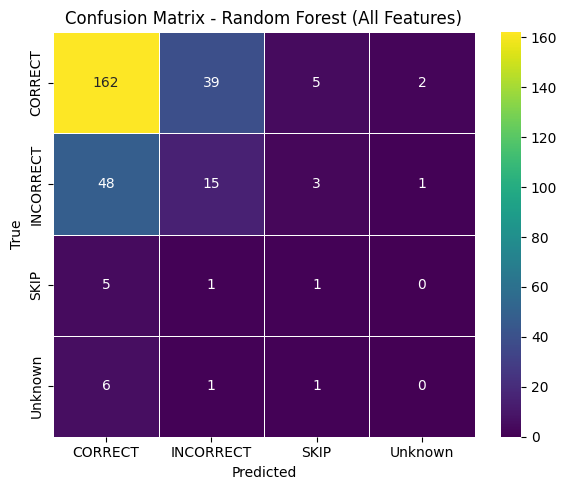

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

# Regenerate X_test with all features within this cell's scope
feature_cols = [c for c in df_features.columns
                if c not in ['Student_ID','routineStart','routineEnd','verdict','QuestionKey','label', 'Key', 'Category', 'QuestionNumber', 'matchOrnomatch', 'Difficulty', 'File_Type', 'routineStamp']]
X_df_all = df_features[feature_cols].copy()
X_df_all = X_df_all.replace([np.inf, -np.inf], np.nan).fillna(0)
X_all = X_df_all.values
y_all = df_features['verdict'].astype(str).values

# Re-split the data to get the correct train/test split for all features
train_idx_all, test_idx_all = train_test_split(df_features.index, test_size=0.2, stratify=y_all, random_state=42)
X_train_all, X_test_all = X_all[train_idx_all], X_all[test_idx_all]
y_train_all, y_test_all = y_all[train_idx_all], y_all[test_idx_all]


# Use the correct X_test for prediction and the Random Forest model
y_pred_rf = rf.predict(X_test_all)  # Use X_test_all and the 'rf' model

# Compute confusion matrix
# Need the original y_test (not encoded) for the confusion matrix.
# Using y_test_all from the re-split
cm_rf = confusion_matrix(y_test_all, y_pred_rf, labels=np.unique(y_test_all))
labels = np.unique(y_test_all)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='viridis', linecolor='white', linewidths=.5,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Random Forest (All Features)') # Update title for Random Forest
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# XGBoost

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb = XGBClassifier(n_estimators=300, random_state=42, tree_method='hist')
xgb.fit(X_train, y_train_encoded) # Use encoded training labels

# For evaluation, we need to predict with the encoded labels and then use the original labels for reporting
y_pred_encoded = xgb.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded) # Convert predictions back to original labels

print("XGBoost:\n", classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

XGBoost:
               precision    recall  f1-score   support

     CORRECT       0.74      0.81      0.78       208
   INCORRECT       0.33      0.25      0.29        67
        SKIP       0.00      0.00      0.00         7
     Unknown       0.00      0.00      0.00         8

    accuracy                           0.64       290
   macro avg       0.27      0.27      0.27       290
weighted avg       0.61      0.64      0.62       290

[[169  31   6   2]
 [ 48  17   1   1]
 [  4   3   0   0]
 [  6   1   1   0]]


# Saving the model

In [ ]:
model_path = os.path.join(models_dir, "xg_allfeatures.pkl")

# Create the directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"✅ Directory created at {models_dir}")


if not os.path.exists(model_path):
    dump(rf, model_path)
    print(f"✅ Model saved to {model_path}")
else:
    print(f"⚠️ Model already exists at {model_path}. Skipping save.")

⚠️ Model already exists at /content/drive/MyDrive/IITB/models/xg_allfeatures.pkl. Skipping save.


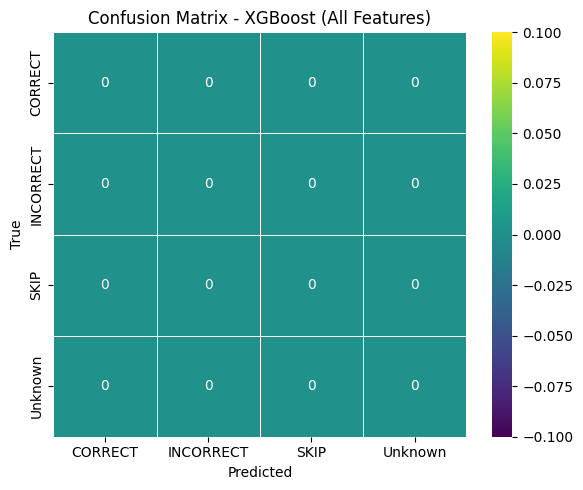

In [ ]:
# Regenerate X_test with all features within this cell's scope
feature_cols = [c for c in df_features.columns
                if c not in ['Student_ID','routineStart','routineEnd','verdict','QuestionKey','label', 'Key', 'Category', 'QuestionNumber', 'matchOrnomatch', 'Difficulty', 'File_Type', 'routineStamp']]
X_df_all = df_features[feature_cols].copy()
X_df_all = X_df_all.replace([np.inf, -np.inf], np.nan).fillna(0)
X_all = X_df_all.values
y_all = df_features['verdict'].astype(str).values

# Re-split the data to get the correct train/test split for all features
train_idx_all, test_idx_all = train_test_split(df_features.index, test_size=0.2, stratify=y_all, random_state=42)
X_train_all, X_test_all = X_all[train_idx_all], X_all[test_idx_all]
y_train_all, y_test_all = y_all[train_idx_all], y_all[test_idx_all]


# Use the correct X_test for prediction
y_pred = xgb.predict(X_test_all)  # Use X_test_all here

# Compute confusion matrix
# Need the original y_test (not encoded) for the confusion matrix.
# Using y_test_all from the re-split
cm = confusion_matrix(y_test_all, y_pred, labels=np.unique(y_test_all))
labels = np.unique(y_test_all)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', linecolor='white', linewidths=.5, # Added linecolor and linewidths
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - XGBoost (All Features)') # Update title based on the model used
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


# Logistic Regression (need scaled features)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial')
lr.fit(X_train_scaled, y_train)
print("Logistic Regression:\n", classification_report(y_test, lr.predict(X_test_scaled)))
print(confusion_matrix(y_test, lr.predict(X_test_scaled)))

Logistic Regression:
               precision    recall  f1-score   support

     CORRECT       0.69      0.47      0.56       208
   INCORRECT       0.22      0.24      0.23        67
        SKIP       0.10      0.43      0.16         7
     Unknown       0.02      0.12      0.04         8

    accuracy                           0.41       290
   macro avg       0.26      0.32      0.25       290
weighted avg       0.54      0.41      0.46       290

[[98 54 19 37]
 [38 16  8  5]
 [ 2  2  3  0]
 [ 5  2  0  1]]


# Saving the model

In [ ]:
model_path = os.path.join(models_dir, "logreg_scalefeatures.pkl")

# Create the directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"✅ Directory created at {models_dir}")


if not os.path.exists(model_path):
    dump(rf, model_path)
    print(f"✅ Model saved to {model_path}")
else:
    print(f"⚠️ Model already exists at {model_path}. Skipping save.")

⚠️ Model already exists at /content/drive/MyDrive/IITB/models/logreg_scalefeatures.pkl. Skipping save.


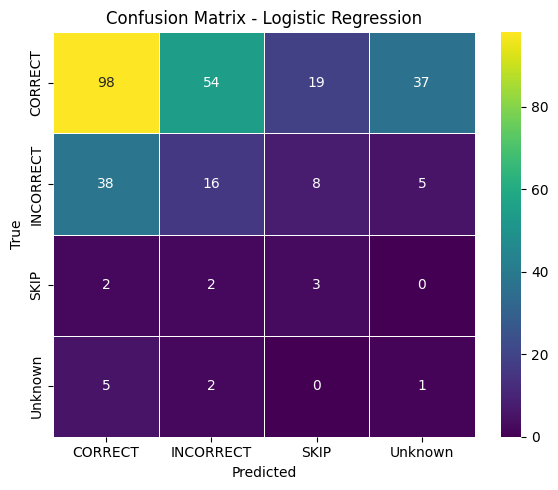

In [ ]:
# Use the Logistic Regression model (lr) and the scaled test data (X_test_scaled)
# The y_test variable from cell 0jYIulPOGJIj should be used for true labels
y_pred_lr = lr.predict(X_test_scaled)

# Compute confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=np.unique(y_test))
labels = np.unique(y_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='viridis', linecolor='white', linewidths=.5,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

***EEG-only Model***

In [ ]:
print(df_features.columns.tolist())

['Key', 'Category', 'QuestionNumber', 'matchOrnomatch', 'Difficulty', 'verdict', 'ResponseTime', 'routineStart', 'routineStamp', 'routineEnd', 'Cat2FeedbackTime', 'Student_ID', 'File_Type', 'delta_mean', 'delta_std', 'theta_mean', 'theta_std', 'alpha_mean', 'alpha_std', 'beta_mean', 'beta_std', 'gamma_mean', 'gamma_std', 'alpha_asymmetry', 'Anger_mean', 'Anger_std', 'Anger_max', 'Contempt_mean', 'Contempt_std', 'Contempt_max', 'Disgust_mean', 'Disgust_std', 'Disgust_max', 'Fear_mean', 'Fear_std', 'Fear_max', 'Joy_mean', 'Joy_std', 'Joy_max', 'Sadness_mean', 'Sadness_std', 'Sadness_max', 'Surprise_mean', 'Surprise_std', 'Surprise_max', 'Engagement_mean', 'Engagement_std', 'Engagement_max', 'Valence_mean', 'Valence_std', 'Valence_max', 'Sentimentality_mean', 'Sentimentality_std', 'Sentimentality_max', 'Confusion_mean', 'Confusion_std', 'Confusion_max', 'Neutral_mean', 'Neutral_std', 'Neutral_max', 'Attention_mean', 'Attention_std', 'Attention_max', 'Brow Furrow_mean', 'Brow Furrow_occurr

In [ ]:
eeg_cols = [c for c in df_features.columns if c.startswith(('delta','theta','alpha','beta','gamma'))]
X_eeg = df_features[eeg_cols].replace([np.inf,-np.inf],np.nan).fillna(0).values
y = df_features['verdict'].astype(str).values

train_idx, test_idx = train_test_split(df_features.index, test_size=0.2, stratify=y, random_state=42)
X_train, y_train = X_eeg[train_idx], y[train_idx]
X_test, y_test = X_eeg[test_idx], y[test_idx]

rf_eeg = RandomForestClassifier(n_estimators=300, random_state=42)
rf_eeg.fit(X_train, y_train)
print("EEG only RF:\n", classification_report(y_test, rf_eeg.predict(X_test)))
print(confusion_matrix(y_test, rf_eeg.predict(X_test)))

EEG only RF:
               precision    recall  f1-score   support

     CORRECT       0.72      1.00      0.83       208
   INCORRECT       0.00      0.00      0.00        67
        SKIP       0.00      0.00      0.00         7
     Unknown       0.00      0.00      0.00         8

    accuracy                           0.71       290
   macro avg       0.18      0.25      0.21       290
weighted avg       0.52      0.71      0.60       290

[[207   1   0   0]
 [ 66   0   0   1]
 [  7   0   0   0]
 [  8   0   0   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


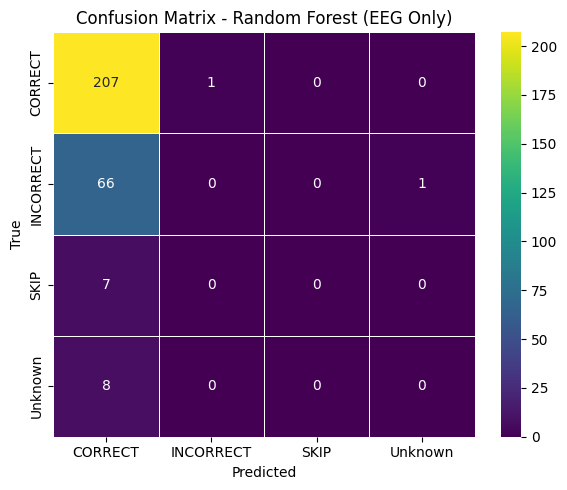

In [ ]:
# Use the EEG-only Random Forest model (rf_eeg) and the EEG-only test data
# The X_test and y_test variables from cell 9GJLEn0vHJHQ should be used
y_pred_rf_eeg = rf_eeg.predict(X_test)

# Compute confusion matrix
cm_rf_eeg = confusion_matrix(y_test, y_pred_rf_eeg, labels=np.unique(y_test))
labels = np.unique(y_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_eeg, annot=True, fmt='d', cmap='viridis', linecolor='white', linewidths=.5,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Random Forest (EEG Only)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

Saving model

In [ ]:
model_path = os.path.join(models_dir, "rf_eeg.pkl")

# Create the directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"✅ Directory created at {models_dir}")


if not os.path.exists(model_path):
    dump(rf, model_path)
    print(f"✅ Model saved to {model_path}")
else:
    print(f"⚠️ Model already exists at {model_path}. Skipping save.")

⚠️ Model already exists at /content/drive/MyDrive/IITB/models/rf_eeg.pkl. Skipping save.


## Macro-F1 Score Comparison Plot

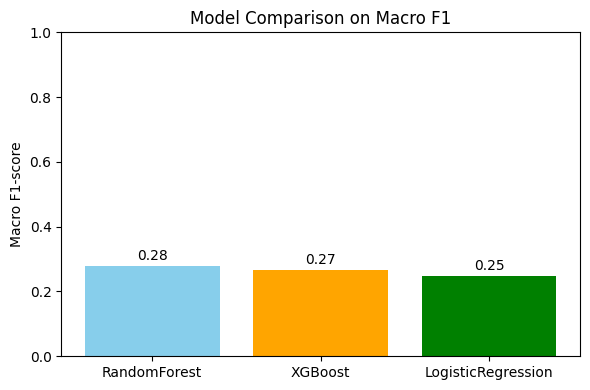

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Regenerate X_test with all features within this cell's scope
feature_cols = [c for c in df_features.columns
                if c not in ['Student_ID','routineStart','routineEnd','verdict','QuestionKey','label', 'Key', 'Category', 'QuestionNumber', 'matchOrnomatch', 'Difficulty', 'File_Type', 'routineStamp']]
X_df_all = df_features[feature_cols].copy()
X_df_all = X_df_all.replace([np.inf, -np.inf], np.nan).fillna(0)
X_all = X_df_all.values
y_all = df_features['verdict'].astype(str).values

# Re-split the data to get the correct train/test split for all features
train_idx_all, test_idx_all = train_test_split(df_features.index, test_size=0.2, stratify=y_all, random_state=42)
X_train_all, X_test_all = X_all[train_idx_all], X_all[test_idx_all]
y_train_all, y_test_all = y_all[train_idx_all], y_all[test_idx_all]

# Need the LabelEncoder fitted on the training data to decode XGBoost predictions
# Assuming 'le' was fitted in cell 8BQq8Q63D6CN - if not, you might need to refit it here
# For robustness, let's refit it here to ensure it's available in this cell's scope
le = LabelEncoder()
le.fit(y_train_all) # Fit encoder on the training labels (all features split)


# --- After training your models and having predictions ---
models = {
    'RandomForest': rf.predict(X_test_all), # Predictions are strings
    'XGBoost': le.inverse_transform(xgb.predict(X_test_all)), # Decode XGBoost predictions
    'LogisticRegression': lr.predict(X_test_scaled) # Predictions are strings
}

f1_scores = {}
for name, y_pred in models.items():
    f1_scores[name] = f1_score(y_test_all, y_pred, average='macro') # Use y_test_all

# Plot
plt.figure(figsize=(6,4))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['skyblue','orange','green'])
plt.ylabel('Macro F1-score')
plt.title('Model Comparison on Macro F1')
for i,(model,score) in enumerate(f1_scores.items()):
    plt.text(i, score+0.01, f"{score:.2f}", ha='center', va='bottom')
plt.ylim(0,1.0)
plt.tight_layout()
plt.show()

## Model Performance Comparison Across Feature Sets and Algorithms

In [ ]:
from sklearn.metrics import classification_report
# Regenerate test sets for all models within this cell's scope

# All Features Test Set
feature_cols_all = [c for c in df_features.columns
                    if c not in ['Student_ID','routineStart','routineEnd','verdict','QuestionKey','label', 'Key', 'Category', 'QuestionNumber', 'matchOrnomatch', 'Difficulty', 'File_Type', 'routineStamp']]
X_df_all = df_features[feature_cols_all].copy()
X_df_all = X_df_all.replace([np.inf, -np.inf], np.nan).fillna(0)
X_all = X_df_all.values
y_all = df_features['verdict'].astype(str).values
train_idx_all, test_idx_all = train_test_split(df_features.index, test_size=0.2, stratify=y_all, random_state=42)
X_test_all = X_all[test_idx_all]
y_test_all = y_all[test_idx_all]

# EEG Only Test Set
eeg_cols = [c for c in df_features.columns if c.startswith(('delta','theta','alpha','beta','gamma'))]
X_eeg = df_features[eeg_cols].replace([np.inf,-np.inf],np.nan).fillna(0).values
train_idx_eeg, test_idx_eeg = train_test_split(df_features.index, test_size=0.2, stratify=y_all, random_state=42) # Use y_all for stratification
X_test_eeg = X_eeg[test_idx_eeg]
y_test_eeg = y_all[test_idx_eeg] # Use y_all for consistency

# Scaled All Features Test Set (for Logistic Regression)
scaler = StandardScaler()
X_train_all_scaled = scaler.fit_transform(X_all[train_idx_all]) # Fit on training data
X_test_all_scaled = scaler.transform(X_test_all) # Transform test data


# Get predictions for each model
y_pred_rf_all = rf.predict(X_test_all)
y_pred_xgb_all = le.inverse_transform(xgb.predict(X_test_all)) # Decode XGBoost predictions
y_pred_lr_all = lr.predict(X_test_all_scaled) # Use scaled test data
y_pred_rf_eeg = rf_eeg.predict(X_test_eeg)


# Generate classification reports and store metrics
report_rf_all = classification_report(y_test_all, y_pred_rf_all, output_dict=True)
report_xgb_all = classification_report(y_test_all, y_pred_xgb_all, output_dict=True)
report_lr_all = classification_report(y_test_all, y_pred_lr_all, output_dict=True)
report_rf_eeg = classification_report(y_test_eeg, y_pred_rf_eeg, output_dict=True)


# Extract metrics and create a comparative DataFrame
metrics_data = []

models = {
    'Random Forest (All Features)': report_rf_all,
    'XGBoost (All Features)': report_xgb_all,
    'Logistic Regression (All Features)': report_lr_all,
    'Random Forest (EEG Only)': report_rf_eeg
}

for model_name, report in models.items():
    for class_name in ['CORRECT', 'INCORRECT', 'SKIP', 'Unknown', 'accuracy', 'macro avg', 'weighted avg']:
        if class_name in report:
            if class_name in ['accuracy']:
                 metrics_data.append({
                    'Model': model_name,
                    'Class': class_name,
                    'Precision': None,
                    'Recall': None,
                    'F1-Score': report[class_name],
                    'Support': None
                })
            else:
                metrics_data.append({
                    'Model': model_name,
                    'Class': class_name,
                    'Precision': report[class_name]['precision'],
                    'Recall': report[class_name]['recall'],
                    'F1-Score': report[class_name]['f1-score'],
                    'Support': report[class_name]['support']
                })

df_metrics = pd.DataFrame(metrics_data)

# Display the comparative table
display(df_metrics)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Class,Precision,Recall,F1-Score,Support
0,Random Forest (All Features),CORRECT,0.733032,0.778846,0.755245,208.0
1,Random Forest (All Features),INCORRECT,0.267857,0.223881,0.243902,67.0
2,Random Forest (All Features),SKIP,0.100000,0.142857,0.117647,7.0
3,Random Forest (All Features),Unknown,0.000000,0.000000,0.000000,8.0
4,Random Forest (All Features),accuracy,NaN,NaN,0.613793,NaN
5,Random Forest (All Features),macro avg,0.275222,0.286396,0.279199,290.0
6,Random Forest (All Features),weighted avg,0.590059,0.613793,0.600882,290.0
7,XGBoost (All Features),CORRECT,0.744493,0.812500,0.777011,208.0
8,XGBoost (All Features),INCORRECT,0.326923,0.253731,0.285714,67.0
9,XGBoost (All Features),SKIP,0.000000,0.000000,0.000000,7.0


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_metrics)

https://docs.google.com/spreadsheets/d/1e7zw9lwN0t-c9uGxZRlw5vjS9NuQ4Y7pIqsriX1NSKk/edit#gid=0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GroupKFold

# 1️⃣ Prepare X, y, and groups (Student_ID)
exclude_cols = ['Student_ID','verdict',
                'Key','QuestionNumber','matchOrnomatch','Difficulty','File_Type', 'routineStart', 'routineEnd', 'routineStamp']
feature_cols = [c for c in df_features.columns if c not in exclude_cols]

X = df_features[feature_cols].fillna(0).replace([np.inf,-np.inf],0).values
y = df_features['verdict'].astype(str).values
groups = df_features['Student_ID'].values  # one group per student

# 2️⃣ Set up GroupKFold
gkf = GroupKFold(n_splits=5)  # 5 folds across students

all_acc, all_f1 = [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n=== Fold {fold+1} ===")
    X_train, y_train = X[train_idx], y[train_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    # 3️⃣ Train a Random Forest (or any model)
    rf = RandomForestClassifier(n_estimators=300,
                                class_weight='balanced',
                                random_state=42,
                                n_jobs=-1)
    rf.fit(X_train, y_train)

    # 4️⃣ Evaluate
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print("Accuracy:", acc)
    print("Macro F1:", f1)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    all_acc.append(acc)
    all_f1.append(f1)

print("\n=== Cross-Participant Results ===")
print("Mean Accuracy:", np.mean(all_acc))
print("Mean Macro-F1:", np.mean(all_f1))


=== Fold 1 ===
Accuracy: 0.7218543046357616
Macro F1: 0.20961538461538462
              precision    recall  f1-score   support

     CORRECT       0.72      1.00      0.84       218
   INCORRECT       0.00      0.00      0.00        72
        SKIP       0.00      0.00      0.00         5
     Unknown       0.00      0.00      0.00         7

    accuracy                           0.72       302
   macro avg       0.18      0.25      0.21       302
weighted avg       0.52      0.72      0.61       302

[[218   0   0   0]
 [ 72   0   0   0]
 [  5   0   0   0]
 [  7   0   0   0]]

=== Fold 2 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6689419795221843
Macro F1: 0.20040899795501022
              precision    recall  f1-score   support

     CORRECT       0.67      1.00      0.80       196
   INCORRECT       0.00      0.00      0.00        79
        SKIP       0.00      0.00      0.00         9
     Unknown       0.00      0.00      0.00         9

    accuracy                           0.67       293
   macro avg       0.17      0.25      0.20       293
weighted avg       0.45      0.67      0.54       293

[[196   0   0   0]
 [ 79   0   0   0]
 [  9   0   0   0]
 [  9   0   0   0]]

=== Fold 3 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7704918032786885
Macro F1: 0.21799628942486085
              precision    recall  f1-score   support

     CORRECT       0.77      1.00      0.87       235
   INCORRECT       0.00      0.00      0.00        50
        SKIP       0.00      0.00      0.00        11
     Unknown       0.00      0.00      0.00         9

    accuracy                           0.77       305
   macro avg       0.19      0.25      0.22       305
weighted avg       0.60      0.77      0.67       305

[[235   0   0   0]
 [ 50   0   0   0]
 [ 10   1   0   0]
 [  9   0   0   0]]

=== Fold 4 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.6934306569343066
Macro F1: 0.20474137931034483
              precision    recall  f1-score   support

     CORRECT       0.69      1.00      0.82       190
   INCORRECT       0.00      0.00      0.00        74
        SKIP       0.00      0.00      0.00         3
     Unknown       0.00      0.00      0.00         7

    accuracy                           0.69       274
   macro avg       0.17      0.25      0.20       274
weighted avg       0.48      0.69      0.57       274

[[190   0   0   0]
 [ 74   0   0   0]
 [  3   0   0   0]
 [  7   0   0   0]]

=== Fold 5 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7299270072992701
Macro F1: 0.28801049696572084
              precision    recall  f1-score   support

     CORRECT       0.74      0.98      0.84       202
   INCORRECT       0.00      0.00      0.00        57
        SKIP       0.00      0.00      0.00         9
     Unknown       0.29      0.33      0.31         6

    accuracy                           0.73       274
   macro avg       0.26      0.33      0.29       274
weighted avg       0.55      0.73      0.63       274

[[198   0   0   4]
 [ 57   0   0   0]
 [  8   0   0   1]
 [  4   0   0   2]]

=== Cross-Participant Results ===
Mean Accuracy: 0.7169291503340423
Mean Macro-F1: 0.22415450965426426


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
